In [1]:
import tensorflow as tf 
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from numpy import exp, log
import winsound
from sklearn.discriminant_analysis import StandardScaler

In [2]:
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir(date, name):
    run_id = time.strftime(date)
    return os.path.join(root_logdir, run_id, name)

In [3]:
cifar10 = keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

train_images = train_images.reshape(-1, 32 * 32 * 3)
test_images = test_images.reshape(-1, 32 * 32 * 3)

scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)

one_hot = np.zeros((len(train_labels), 10))
one_hot_test = np.zeros((len(test_labels), 10))

for i, label in enumerate(train_labels):
    one_hot[i][label] = 1

for i, label in enumerate(test_labels):
    one_hot_test[i][label] = 1

train_labels = one_hot
test_labels = one_hot_test

train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2)

In [4]:
class CustomAlphaDropout(tf.keras.layers.Layer):
    def __init__(self, rate=0.1, noise_shape=None, seed=None, **kwargs):
        """
        Custom AlphaDropout layer that applies dropout for SELU activations.

        Args:
            rate (float): Dropout rate (between 0 and 1).
            noise_shape (1D tensor of int or None): 1D shape tuple representing the 
                shape of the binary dropout mask that will be multiplied with 
                the input. For instance, if input shape is (None, 32, 32, 3) 
                and noise_shape is (32, 32, 1), the dropout mask will be 
                broadcasted to (None, 32, 32, 3).
            seed (int or None): Random seed for reproducibility.
            **kwargs: Additional keyword arguments for the Layer.
        """
        super(CustomAlphaDropout, self).__init__(**kwargs)
        self.rate = rate
        self.noise_shape = noise_shape
        self.seed = seed
        self.alpha = 1.6732632423543772848170429916717 
        self.scale = 1.0507009873554804934193349852946 

    def build(self, input_shape):
        self.input_shape = input_shape
        super(CustomAlphaDropout, self).build(input_shape)

    def call(self, inputs, training=None):
        # Ensure training is a Tensor
        training = tf.convert_to_tensor(training, dtype=tf.bool)

        def dropped_inputs():
            # Determine the noise shape
            noise_shape = self.noise_shape or tf.shape(inputs)
            random_tensor = tf.random.uniform(noise_shape, seed=self.seed)
            keep_prob = 1.0 - self.rate
            
            # Create binary tensor
            binary_tensor = tf.cast(random_tensor >= self.rate, inputs.dtype)
            alpha_dropout_scale = self.scale * (binary_tensor + keep_prob - 1.0)
            alpha_dropout_shift = self.alpha * (1.0 - binary_tensor)

            # Apply the dropout and the affine transformation
            return inputs * alpha_dropout_scale + alpha_dropout_shift

        # Use tf.cond to switch between training and inference modes
        return tf.cond(training, dropped_inputs, lambda: inputs)

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {
            "rate": self.rate,
            "noise_shape": self.noise_shape,
            "seed": self.seed,
        }
        base_config = super(CustomAlphaDropout, self).get_config()
        return {**base_config, **config}

In [5]:
# type corresponds to the type of model to be built as per exercise instructions
# each type consists of 20 dense layers with 100 neurons each with Nadam optimizer
# type 1: HE initialization, ELU activation
# type 2: HE initialization, ELU activation, Batch Normalization
# type 3: Lecun initialization, SELU activation
# type 4: Lecun initialization, SELU activation, AlphaDropout

def build_model(learning_rate=3e-3, type=1):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(3072,)))

    if type == 1:
        for i in range(20):
            model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
    elif type == 2:
        for i in range(20):
            model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
            model.add(keras.layers.BatchNormalization())
    elif type == 3:
        for i in range(20):
            model.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
    elif type == 4:
        for i in range(20):
            model.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
            model.add(CustomAlphaDropout(rate=0.05))
    else:
        print("Invalid type")
        return

    model.add(keras.layers.Dense(10, activation="softmax"))
    
    optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

    return model

In [6]:
class LRFinder(keras.callbacks.Callback):
    def __init__(self, start_lr=1e-5, end_lr=1e-1, num_iterations=50, max_loss=300):
        super().__init__()
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_iterations = num_iterations
        self.learning_rates = []
        self.losses = []
        self.iteration = 0
        self.multiplier = (end_lr/start_lr)**(1/num_iterations)
        self.max_loss = max_loss
        self.optimal_lr = None

    def on_train_batch_begin(self, batch, logs=None):
        lr = self.start_lr * (self.multiplier ** self.iteration)
        self.model.optimizer.learning_rate.assign(lr)
        self.learning_rates.append(lr)

    def on_train_batch_end(self, batch, logs=None):
        loss = logs['loss']
        if not np.isnan(loss) and loss < self.max_loss:
            self.losses.append(loss)
        else:
            self.losses.append(None)
        self.iteration += 1
        if self.iteration >= self.num_iterations:
            self.model.stop_training = True

    def plot_loss(self):
        valid_losses = [loss for loss in self.losses if loss is not None]
        valid_learning_rates = [lr for lr, loss in zip(self.learning_rates, self.losses) if loss is not None]
        
        plt.figure(figsize=(10, 6))
        plt.plot(valid_learning_rates, valid_losses)
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate vs. Loss')
        
        min_loss_idx = np.argmin(valid_losses)
        
        optimal_lr = valid_learning_rates[min_loss_idx] / 10
        
        plt.axvline(x=optimal_lr, color='red', linestyle='--', label=f'Optimal LR: {optimal_lr:.2e}')
        plt.legend()
        
        plt.show()

    def get_optimal_lr(self):
        valid_losses = [loss for loss in self.losses if loss is not None]
        valid_learning_rates = [lr for lr, loss in zip(self.learning_rates, self.losses) if loss is not None]
        
        min_loss_idx = np.argmin(valid_losses)
        
        optimal_lr = valid_learning_rates[min_loss_idx] / 10

        return optimal_lr


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


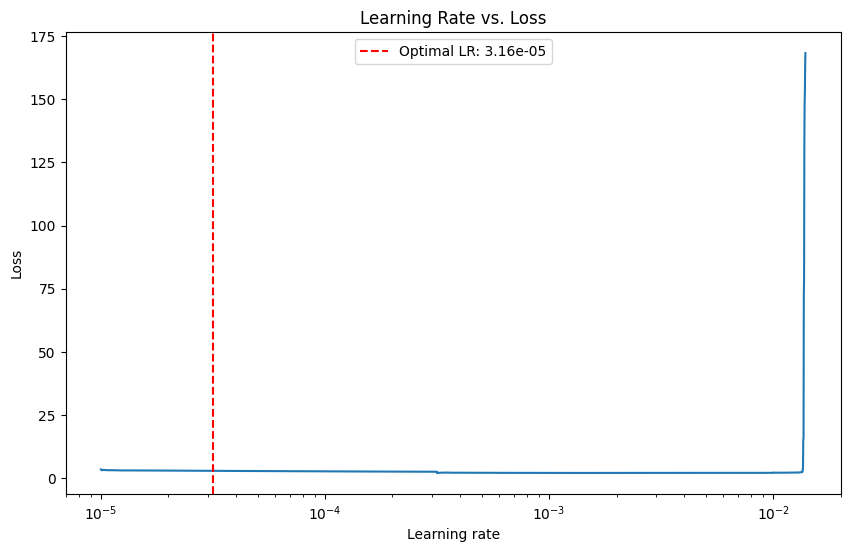

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
LECUN_SELU_ALPHA0.05 - Test Accuracy: 47.19%


In [10]:
# date = time.strftime("%Y_%m_%d-%H_%M")
date ="2024_08_30-15_22"
names = ["HE_ELU", "HE_ELU_BATCH", "LECUN_SELU", "LECUN_SELU_ALPHA0.05"]
models = []

for i in range(4, 5):
    run_logdir = get_run_logdir(date, names[i-1])
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
    lr_finder = LRFinder(start_lr=1e-5, end_lr=10, num_iterations=5000)


    model = build_model(type=i)
    model.fit(train_images, train_labels, epochs=5, validation_data=(val_images, val_labels), callbacks=[lr_finder], verbose=0)
    optimal_lr = lr_finder.get_optimal_lr()
    lr_finder.plot_loss()

    model = build_model(learning_rate=optimal_lr, type=i)
    model.fit(train_images, train_labels, epochs=300, validation_data=(val_images, val_labels),
              callbacks=[tensorboard_cb, early_stop_cb], verbose=0)
    
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels, axis=1)
    accuracy = np.mean(predicted_classes == true_classes)

    print(f"{names[i-1]} - Test Accuracy: {accuracy * 100:.2f}%")

    with open(f"{run_logdir}/accuracy.txt", "a") as f:
        f.write(f"{names[i-1]} - Test Accuracy: {accuracy * 100:.2f}%")
    
winsound.Beep(2500, 4000)
